## Постановка задачи

Проект представляет собой анализ данных матчей Английской Премьер Лиги по футболу. Данные не самые чистые, в них могут быть различные нюансы (дубли, пропуски и т.д.)

По данным нужно ответить на следующие вопросы:

1. Какая команда в среднем забивала больше всего голов за матч? А пропускала?

2. Сколько голов в среднем забивают в первом тайме? А во втором?

3. Как часто команда, выигравшая первый тайм в итоге побеждала?

4. Построить зависимость - ось х: кол-во желтых карточек в матче, ось у: среднее кол-во красных карточек в матчах с соответствующим кол-вом желтых карточек

5. Составить турнирную таблицу за последний сезон (с 11 августа 2023 по 19 мая 2024). За победу команде присуждается 3 очка, за ничью - 1, за поражение - 0

6. (Дополнительно) Какая команда выиграла больше всего матчей, будучи аутсайдером **НА МОМЕНТ МАТЧА**? (Метод определения аутсайдера придумать самому)



### Импорт необходимых библиотек

In [1564]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Загрузка данных

In [1565]:
df = pd.read_csv('epl-training.csv')

#### описание колонок

Containing EPL data from 2000 to 2024
• Date: The date that the match took place

• HomeTeam: The team playing at home

• AwayTeam: The team playing away

• FTHG: The goals scored by the home team at full time

• FTAG: The goals scored by the away team at full time

• FTR: Full time result (This is what you are predicting)

• HTHG: The goals scored by the home team at half time

• HTAG: The goals scored by the away team at half time

• HTR: The result at half time

• Referee: The name of the referee officiating the match

• HS: Total number of shots on goal by the home team

• AS: Total number of shots on goal by the away team

• HST: Total number of shots on target by the home team

• AST: Total number of shots on target by the away team

• HF: Total number of fouls committed by the home team

• AF: Total number of fouls committed by the away team

• HC: Total number of corners by the home team

• AC: Total number of corners by the away team

• HY: Total number of yellow cards received by the home team

• AY: Total number of yellow cards received by the away team

• HR: Total number of red cards received by the home team

• AR: Total number of red cards received by the away team

### Преобразование и очистка данных от дублей, пропусков и выбросов

In [1566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9221 entries, 0 to 9220
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9220 non-null   object 
 1   HomeTeam  9220 non-null   object 
 2   AwayTeam  9220 non-null   object 
 3   FTHG      9220 non-null   float64
 4   FTAG      9220 non-null   float64
 5   FTR       9220 non-null   object 
 6   HTHG      9220 non-null   float64
 7   HTAG      9220 non-null   float64
 8   HTR       9220 non-null   object 
 9   Referee   9220 non-null   object 
 10  HS        9220 non-null   float64
 11  AS        9220 non-null   float64
 12  HST       9220 non-null   float64
 13  AST       9220 non-null   float64
 14  HC        9220 non-null   float64
 15  AC        9220 non-null   float64
 16  HF        9220 non-null   float64
 17  AF        9220 non-null   float64
 18  HY        9220 non-null   float64
 19  AY        9220 non-null   float64
 20  HR        9220 non-null   floa

In [1567]:
# дата представлена в формате object, чтобы с ней можно было работать как с датой, преобразуем её в datetime

df['Date'] = pd.to_datetime(cleaned_df['Date'], format='%d/%m/%Y')
df.dtypes.head(1)


Date    datetime64[ns]
dtype: object

In [1568]:
# найдем пропуски и дубликаты

print(f'пропусков - {df.isnull().sum().sum()}')
print(f'дубликатов - {df.duplicated(keep=False).sum():.0f}')

пропусков - 122
дубликатов - 0


In [1569]:
# теперь возьмем только те колонки, которые интересуют нас в поставленных вопросах

necessary_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HY', 'AY', 'HR', 'AR']
cleaned_df = df[necessary_columns]

# находим пропуски и дубликаты

print(f'пропусков в нужной таблице - {cleaned_df.isnull().sum().sum()}')
print(f'дубликатов в нужной таблице - {cleaned_df.duplicated(keep=False).sum()}')

пропусков в нужной таблице - 113
дубликатов в нужной таблице - 0


##### чистим от пропусков и дублей

In [1570]:
cleaned_df = cleaned_df.drop_duplicates()
cleaned_df = cleaned_df.dropna()
cleaned_df.shape

(9120, 13)

In [1571]:
print(f'пропусков - {cleaned_df.isnull().sum().sum()}')
print(f'уникальных строк - {cleaned_df.nunique(axis = 1).count()}')

пропусков - 0
уникальных строк - 9120


In [1572]:
# разобъём статистику на сезоны и посчитаем количество матчей для каждого сезона

def get_season (date):
    year = date.year
    if date.month >= 8:
        return f"{year}-{year+1}"
    else:
        return f"{year-1}-{year}"
        
cleaned_df['season'] = cleaned_df['Date'].apply(get_season)

all_matches = cleaned_df.groupby('season', as_index = False).agg({'Date':'count', 'HomeTeam':'nunique', 'AwayTeam':'nunique'})

all_matches

,season,Date,HomeTeam,AwayTeam
0,2000-2001,380,20,20
1,2001-2002,380,20,20
2,2002-2003,380,20,20
3,2003-2004,380,20,20
4,2004-2005,380,20,20
5,2005-2006,380,20,20
6,2006-2007,380,20,20
7,2007-2008,380,20,20
8,2008-2009,380,20,20
9,2009-2010,380,20,20


In [1573]:
# получаем по 380 матчей на сезон и 20 уникальных команд в сезоне. По формуле сочетаний сыгранных матчей убедимся,
# что разбивка прошла верно. 

math.factorial(20) * 2 / (math.factorial(2) * math.factorial(20 - 2))

380.0

In [1574]:
# считаем, что данные преобразованы верно, можно отвечать на поставленные вопросы

### Какая команда в среднем забивала больше всего голов за матч? А пропускала?

In [1575]:
# посчитаем количество забитых голов
home_scored_goals = cleaned_df[['HomeTeam', 'FTHG']].rename(columns={'HomeTeam': 'team', 'FTHG':'scored_goals'})
away_scored_goals = cleaned_df[['AwayTeam', 'FTAG']].rename(columns={'AwayTeam': 'team', 'FTAG':'scored_goals'})

# посчитаем количество пропущенных голов
home_missed_goals = cleaned_df[['HomeTeam', 'FTAG']].rename(columns={'HomeTeam': 'team', 'FTAG':'missed_goals'})
away_missed_goals = cleaned_df[['AwayTeam', 'FTHG']].rename(columns={'AwayTeam': 'team', 'FTHG':'missed_goals'})

# посчитаем количество забитых и пропущенных голов суммарно дома и в гостях
total_scored_goals = pd.concat([home_scored_goals, away_scored_goals], axis = 0)
total_missed_goals = pd.concat([home_missed_goals, away_missed_goals], axis = 0)

# посчитаем среднее количество забитых и пропущенных голов в разрезе команд
mean_scored_goals = total_scored_goals.groupby('team').agg({'scored_goals':'mean'}).reset_index()
mean_missed_goals = total_missed_goals.groupby('team').agg({'missed_goals':'mean'}).reset_index()

# ответим на поставленный вопрос
max_mean_scored_goals = mean_scored_goals.loc[mean_scored_goals['scored_goals'].idxmax()]
max_mean_missed_goals = mean_missed_goals.loc[mean_missed_goals['missed_goals'].idxmax()]

In [1576]:
print(f'Команда {max_mean_scored_goals.team} в среднем забивала больше всего голов за матч - \
{max_mean_scored_goals.scored_goals:.1f}')

print(f'Команда {max_mean_missed_goals.team} в среднем пропускала больше всего голов за матч - \
{max_mean_missed_goals.missed_goals:.1f}')

Команда Man City в среднем забивала больше всего голов за матч - 1.9
Команда Luton в среднем пропускала больше всего голов за матч - 2.2


### Сколько голов в среднем забивают в первом тайме? А во втором?

In [1577]:
# создадим df goals с нужными столбцами
goals = cleaned_df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG']].reset_index()

# посчитаем количество забитых голов во втором тайме дома и в гостях
goals['second_period_home_goals'] = goals['FTHG'] - goals['HTHG']
goals['second_period_away_goals'] = goals['FTAG'] - goals['HTAG']

# посчитаем количество забитых голов в первом тайме дома и в гостях
first_half_home_scored_goals = goals[['HomeTeam', 'HTHG']].rename(columns={'HomeTeam': 'team', 'HTHG':'scored_goals'})
first_half_away_scored_goals = goals[['AwayTeam', 'HTAG']].rename(columns={'AwayTeam': 'team', 'HTAG':'scored_goals'})

# посчитаем количество забитых голов во втором тайме дома и в гостях
second_half_home_scored_goals = goals[['HomeTeam', 'second_period_home_goals']].rename(columns={'HomeTeam': 'team', 'second_period_home_goals':'scored_goals'})
second_half_away_scored_goals = goals[['AwayTeam', 'second_period_away_goals']].rename(columns={'AwayTeam': 'team', 'second_period_away_goals':'scored_goals'})

# посчитаем общеем количество забитых в первом и во втором тайме
first_half_scored_goals = pd.concat([first_half_home_scored_goals, first_half_away_scored_goals], axis = 0)
second_half_scored_goals = pd.concat([second_half_home_scored_goals, second_half_away_scored_goals], axis = 0)

print (f'В среднем в первом тайме забивают {first_half_scored_goals["scored_goals"].mean():.1f} мячей, а во втором - {second_half_scored_goals["scored_goals"].mean():.1f}')

В среднем в первом тайме забивают 0.6 мячей, а во втором - 0.8


In [1578]:
goals.head()

,index,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,second_period_home_goals,second_period_away_goals
0,0,Charlton,Man City,4.0,0.0,2.0,0.0,2.0,0.0
1,1,Chelsea,West Ham,4.0,2.0,1.0,0.0,3.0,2.0
2,2,Coventry,Middlesbrough,1.0,3.0,1.0,1.0,0.0,2.0
3,3,Derby,Southampton,2.0,2.0,1.0,2.0,1.0,0.0
4,4,Leeds,Everton,2.0,0.0,2.0,0.0,0.0,0.0


### Как часто команда, выигравшая первый тайм в итоге побеждала?

In [1579]:
# создадим df с результатами матчей в целом промежуточными (после первого тайма)
game_results = cleaned_df[['HomeTeam', 'AwayTeam', 'FTR', 'HTR']]

# посчитаем команды, ведущие после первого тайма
first_half_winners = game_results[(game_results['HTR'] == 'H') | (game_results['HTR'] == 'A')]

# посчитаем победителей, которые также вели после первого тайма
half_and_game_winners = first_half_winners[first_half_winners['FTR'] == first_half_winners['HTR']]

# расчитаем процент команд, которые выиграли первый тайм и по итогу победили
percentage = len(half_and_game_winners) / len(first_half_winners) * 100

print(f'Команда, выигравшая первый тайм побеждала в {percentage:.0f}% случаев')

Команда, выигравшая первый тайм побеждала в 76% случаев


### Построить зависимость - ось х: кол-во желтых карточек в матче, ось у: среднее кол-во красных карточек в матчах с соответствующим кол-вом желтых карточек


In [1580]:
# создадим df с полученными за игру карточками
cards = cleaned_df[['HomeTeam', 'AwayTeam', 'HY', 'AY', 'HR', 'AR']].reset_index()

# добавим столбцы с общим числом желтых и красных карточкам
cards['yellow_cards'] = cards['HY'] + cards['AY']
cards['red_cards'] = cards['HR'] + cards['AR']

cards.head()

,index,HomeTeam,AwayTeam,HY,AY,HR,AR,yellow_cards,red_cards
0,0,Charlton,Man City,1.0,2.0,0.0,0.0,3.0,0.0
1,1,Chelsea,West Ham,1.0,2.0,0.0,0.0,3.0,0.0
2,2,Coventry,Middlesbrough,5.0,3.0,1.0,0.0,8.0,1.0
3,3,Derby,Southampton,1.0,1.0,0.0,0.0,2.0,0.0
4,4,Leeds,Everton,1.0,3.0,0.0,0.0,4.0,0.0


In [1581]:
# есть 29 матчей за всю статистику, когда красные карточки выдавались сразу
# и 9 матчей, когда количество красных карточек превысило количество желтых
# Скорее всего имели место грубые нарушения, поэтому не будем считать это за выброс или ошибку

len(cards[(cards['yellow_cards'] == 0) & (cards['red_cards'] != 0)])

29

In [1582]:
len(cards[(cards['yellow_cards'] < cards['red_cards']) & (cards['yellow_cards'] != 0)])

9

In [1583]:
# расчитаем среднее число красных карточек в разрезе количества жёлтых
avg_red_cards_per_yellow = cards.groupby('yellow_cards', as_index = False).agg({'red_cards':'mean'})

In [1584]:
avg_red_cards_per_yellow

,yellow_cards,red_cards
0,0.0,0.056437
1,1.0,0.097315
2,2.0,0.119977
3,3.0,0.142412
4,4.0,0.174789
5,5.0,0.201486
6,6.0,0.225042
7,7.0,0.170000
8,8.0,0.198630
9,9.0,0.387755


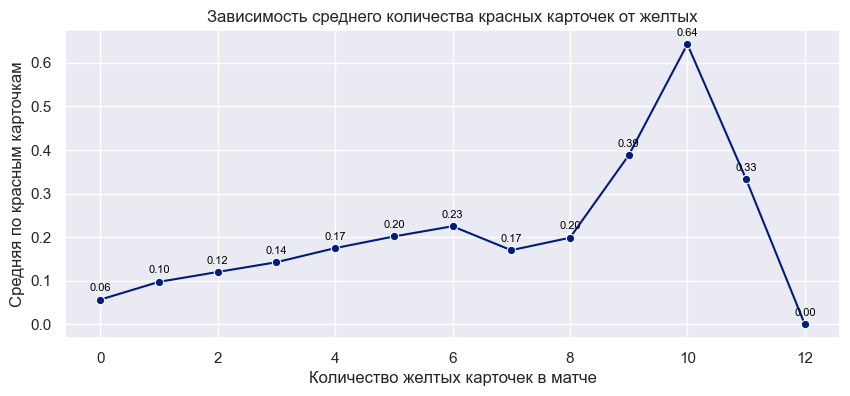

In [1585]:
# настроим размер полотна
plt.figure(figsize=(10, 4))

# настроим стиль и палитру
sns.set(style = 'darkgrid', palette = 'dark')

# создадим линейный график
ax = sns.lineplot(data = avg_red_cards_per_yellow, x = 'yellow_cards', y = 'red_cards', marker = 'o')

# добавим значения на график
for index, row in avg_red_cards_per_yellow.iterrows():
    ax.text(row['yellow_cards'], row['red_cards'] + 0.015, f"{row['red_cards']:.2f}", color='black', fontsize=8, ha='center', va='bottom')

plt.xlabel('Количество желтых карточек в матче')
plt.ylabel('Средняя по красным карточкам')
plt.title('Зависимость среднего количества красных карточек от желтых')

plt.show()

### Составить турнирную таблицу за последний сезон (с 11 августа 2023 по 19 мая 2024). За победу команде присуждается 3 очка, за ничью - 1, за поражение - 0

In [1586]:
# даты последнего сезона
start_date = '2023-08-11'
end_date = '2024-05-19'

# создадим df с информацией по последнему сезону
last_season = cleaned_df[(cleaned_df['Date'] >= start_date) & (cleaned_df['Date'] <= end_date)]
last_season = last_season[['Date', 'HomeTeam', 'AwayTeam', 'FTR']]
last_season.head()

,Date,HomeTeam,AwayTeam,FTR
8741,2023-08-11,Burnley,Man City,A
8742,2023-08-12,Arsenal,Nott'm Forest,H
8743,2023-08-12,Bournemouth,West Ham,D
8744,2023-08-12,Brighton,Luton,H
8745,2023-08-12,Everton,Fulham,A


In [1587]:
# создадим пустой словарь для очков команд
team_points = {}

# напишем функцию, которая будет добавлять очки в зависимости от результата
def add_points (team, points):
    # если команда уже есть в словаре, то прибавляем очки
    if team in team_points:
        team_points[team] += points
    # если команды в словаре ещё нет, то добавляем ключ - названик команды и количество очков    
    else:
        team_points[team] = points
        
# пробегаемся по df и применяем функцию к каждой строке        
for i, row in last_season.iterrows():
    if row['FTR'] == 'H':
        add_points(row['HomeTeam'], 3)
    elif row['FTR'] == 'A':
        add_points(row['AwayTeam'], 3)
    elif row['FTR'] == 'D':
        add_points(row['HomeTeam'], 1)
        add_points(row['AwayTeam'], 1)

#преобразуем словарь в df
tournament_table = pd.DataFrame(list(team_points.items()), columns = ['Team', 'Score'])

tournament_table

,Team,Score
0,Man City,91
1,Arsenal,89
2,Bournemouth,48
3,West Ham,52
4,Brighton,48
5,Fulham,47
6,Crystal Palace,49
7,Newcastle,60
8,Brentford,39
9,Tottenham,66


### (Дополнительно) Какая команда выиграла больше всего матчей, будучи аутсайдером НА МОМЕНТ МАТЧА? (Метод определения аутсайдера придумать самому)

In [1588]:
# будем искать аутсайдера матча по следующим критериям:

# по разнице очков, если уже сыграно больше 5 матчей в сезоне
# по количеству очков за прошлый сезон, если сыграно 5 и меньше матчей

In [1589]:
# посчитаем количество очков команд по сезонам

# создадим пустой словарь
team_points_all_seasons = {}

# напишем функцию, которая будет считать очки команд
def add_points_all_seasons(season, team, points):
    # если в словаре ещё нет сезона, то добавляем ключ - сезон и пустой словарь для команды и очков
    if season not in team_points_all_seasons:
        team_points_all_seasons[season] = {}
    # если в сезоне уже есть команда, то добавляем ей очков, а если ещё нет, то добавляем команду и её очки
    if team in team_points_all_seasons[season]:
        team_points_all_seasons[season][team] += points
    else:
        team_points_all_seasons[season][team] = points

# пробегаемся по df и наполняем словарь в зависимости от результата матча
for i, row in cleaned_df.iterrows():
    if row['FTR'] == 'H':
        add_points_all_seasons(row['season'], row['HomeTeam'], 3)
    elif row['FTR'] == 'A':
        add_points_all_seasons(row['season'], row['AwayTeam'], 3)
    elif row['FTR'] == 'D':
        add_points_all_seasons(row['season'], row['HomeTeam'], 1)
        add_points_all_seasons(row['season'], row['AwayTeam'], 1)

# преобразуем словарь в df
team_scores_all_seasons = pd.DataFrame.from_dict(team_points_all_seasons, orient = 'index')

# сжимаем столбцы
team_scores_all_seasons = team_scores_all_seasons.stack().reset_index()

# переименовываем колонки
team_scores_all_seasons.columns = ['season', 'team', 'score']

team_scores_all_seasons.head()

,season,team,score
0,2000-2001,Charlton,52.0
1,2000-2001,Chelsea,61.0
2,2000-2001,Middlesbrough,42.0
3,2000-2001,Derby,42.0
4,2000-2001,Southampton,52.0


In [1590]:
# теперь посчитаем количество сыгранных матчей и набранных очков на момент матча

cleaned_df = cleaned_df.sort_values('Date')

#добавляем новые колонки
cleaned_df['HomeMatches'] = 0
cleaned_df['AwayMatches'] = 0
cleaned_df['HomePoints'] = 0
cleaned_df['AwayPoints'] = 0

# создадим пустой словарь со статистикой текущего сезона
season_stats = {}

# создадим функцию, которая будет возвращать кортеж из очков, которые получают команды за матч
def calculate_points(result):
    if result == 'H':
        return 3, 0 
    elif result == 'A':
        return 0, 3  
    elif result == 'D':
        return 1, 1 

#пробегаемся по df 
for index, row in cleaned_df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    season = row['season']
    result = row['FTR']
    
    #если сезона в словаре нет, то добавляем его 
    if season not in season_stats:
        season_stats[season] = {}
    
    #если домашней команды в сезоне ешё нет, то добавляем команду и нулевое количество матчей/очков
    if home_team not in season_stats[season]:
        season_stats[season][home_team] = {'matches': 0, 'points': 0}
    #если гостевой команды в сезоне ешё нет, то добавляем команду и нулевое количество матчей/очков    
    if away_team not in season_stats[season]:
        season_stats[season][away_team] = {'matches': 0, 'points': 0}

    #заполняем столбцы df в соответствии с полученными данными по матчам и очкам построчно    
    cleaned_df.at[index, 'HomeMatches'] = season_stats[season][home_team]['matches']
    cleaned_df.at[index, 'AwayMatches'] = season_stats[season][away_team]['matches']
    cleaned_df.at[index, 'HomePoints'] = season_stats[season][home_team]['points']
    cleaned_df.at[index, 'AwayPoints'] = season_stats[season][away_team]['points']

    #обновляем результаты после каждого матча
    home_pts, away_pts = calculate_points(result)
    season_stats[season][home_team]['matches'] += 1
    season_stats[season][home_team]['points'] += home_pts
    season_stats[season][away_team]['matches'] += 1
    season_stats[season][away_team]['points'] += away_pts

cleaned_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HY,AY,HR,AR,season,HomeMatches,AwayMatches,HomePoints,AwayPoints
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,1.0,2.0,0.0,0.0,2000-2001,0,0,0,0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,1.0,2.0,0.0,0.0,2000-2001,0,0,0,0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,5.0,3.0,1.0,0.0,2000-2001,0,0,0,0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,1.0,1.0,0.0,0.0,2000-2001,0,0,0,0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,1.0,3.0,0.0,0.0,2000-2001,0,0,0,0


In [1591]:
# создадим функцию, которая возвращает название предыдущего сезона
def get_previous_season_score(current_season):
    start_year, end_year = map(int, current_season.split('-'))
    return f"{start_year-1}-{end_year-1}"

# преобразуем вторую таблицу в словарь
season_scores_dict = team_scores_all_seasons.set_index(['season', 'team'])['score'].to_dict()

# добавляем новые колонки
cleaned_df['HomePointsLastSeason'] = 0
cleaned_df['AwayPointsLastSeason'] = 0

# Заполняем новые колонки
for index, row in cleaned_df.iterrows():
    current_season = row['season']
    previous_season = get_previous_season_score(current_season)
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Заполняем очки домашней команды за прошлый сезон
    if (previous_season, home_team) in season_scores_dict:
        cleaned_df.at[index, 'HomePointsLastSeason'] = season_scores_dict[(previous_season, home_team)]

    # Заполняем очки гостевой команды за прошлый сезон
    if (previous_season, away_team) in season_scores_dict:
        cleaned_df.at[index, 'AwayPointsLastSeason'] = season_scores_dict[(previous_season, away_team)]
        
cleaned_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HY,AY,HR,AR,season,HomeMatches,AwayMatches,HomePoints,AwayPoints,HomePointsLastSeason,AwayPointsLastSeason
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,1.0,2.0,0.0,0.0,2000-2001,0,0,0,0,0,0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,1.0,2.0,0.0,0.0,2000-2001,0,0,0,0,0,0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,5.0,3.0,1.0,0.0,2000-2001,0,0,0,0,0,0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,1.0,1.0,0.0,0.0,2000-2001,0,0,0,0,0,0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,1.0,3.0,0.0,0.0,2000-2001,0,0,0,0,0,0


In [1592]:
# создадим функцию, которая в зависимости от количества сыгранных матчей в сезоне по критерию будет определять аутсайдера
def get_underdog(home_team, away_team, home_matches, away_matches, home_points, away_points, home_points_last_season, away_points_last_season):
    if (home_matches + away_matches) / 2 >= 6:
        home_criteria = home_points
        away_criteria = away_points
    else:
        home_criteria = home_points_last_season
        away_criteria = away_points_last_season
        
    if home_criteria < away_criteria:
        return home_team
    elif away_criteria < home_criteria:
        return away_team
    else:
        return 'equal'
    
cleaned_df['underdog'] = None

# пробегаемся по df
for index, row in cleaned_df.iterrows():
    home_team = row['HomeTeam'] 
    away_team = row['AwayTeam'] 
    home_matches = row['HomeMatches']
    away_matches = row['AwayMatches']
    home_points = row['HomePoints']
    away_points = row['AwayPoints']
    home_points_last = row['HomePointsLastSeason']
    away_points_last = row['AwayPointsLastSeason']

    # определяем аутсайдера и заполняем столбец underdog в cleaned_df
    underdog = get_underdog(home_team, away_team, home_matches, away_matches, home_points, away_points, home_points_last, away_points_last)
    cleaned_df.at[index, 'underdog'] = underdog
    
cleaned_df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HY,...,HR,AR,season,HomeMatches,AwayMatches,HomePoints,AwayPoints,HomePointsLastSeason,AwayPointsLastSeason,underdog
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,1.0,...,0.0,0.0,2000-2001,0,0,0,0,0,0,equal
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,1.0,...,0.0,0.0,2000-2001,0,0,0,0,0,0,equal
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,5.0,...,1.0,0.0,2000-2001,0,0,0,0,0,0,equal
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,1.0,...,0.0,0.0,2000-2001,0,0,0,0,0,0,equal
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,1.0,...,0.0,0.0,2000-2001,0,0,0,0,0,0,equal


In [1593]:
# создадим пустой список для победивших аутсайдеров
winning_underdogs = []

# заполняем список победившими командами-аутсайдерами
for index, row in cleaned_df.iterrows():
    if row['underdog'] == row['HomeTeam'] and row['FTR'] == 'H':
        winning_underdogs.append(row['HomeTeam'])
    elif row['underdog'] == row['AwayTeam'] and row['FTR'] == 'A':
        winning_underdogs.append(row['AwayTeam'])

# преобразуем список в df
winning_underdogs_df = pd.DataFrame(winning_underdogs, columns = ['team'])

# считаем количество выигранных матчей по каждому аутсайдеру
winning_underdogs_counts = winning_underdogs_df.groupby('team').value_counts().reset_index()

winning_underdogs_counts.columns = ['team', 'win_as_underdog']

# находим самого результативного аутсайдера
best_underdog = winning_underdogs_counts.loc[winning_underdogs_counts['win_as_underdog'].idxmax()]

# выведем то 5 результативных аутсайдеров
winning_underdogs_counts.sort_values(by = 'win_as_underdog', ascending = False).head()


,team,win_as_underdog
29,Newcastle,124
43,West Ham,123
17,Everton,111
18,Fulham,105
1,Aston Villa,97


In [1594]:
print (f'Команда {best_underdog["team"]} выиграла больше всего матчей буду аутсайдером - {best_underdog["win_as_underdog"]} матча за все сезоны')

Команда Newcastle выиграла больше всего матчей буду аутсайдером - 124 матча за все сезоны
